# Kalman Filter Multivariado

In [36]:
!pip install pykalman
!pip install johansen 

  Created wheel for johansen: filename=johansen-0.0.4-cp37-none-any.whl size=5633 sha256=d6f5d0180e1c0889d851b2c491231f5ff782d50c95cb70313c82e46d6ad6c7fb
  Stored in directory: C:\Users\mariaalejandra\AppData\Local\pip\Cache\wheels\29\4a\ea\9a38d9ff2246e7a710488e8eaa22da457614a6f639979a59b4
Successfully built johansen


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm

## Importar base de datos

In [100]:
base=pd.read_excel("base_kalman_multivariado.xlsx",index_col=0)#.resample("w").last()

In [101]:
base.columns

Index(['S&P 500 INDEX', 'ISHARES MSCI EAFE ETF', 'BRAZIL IBOVESPA INDEX',
       'S&P/CLX IPSA (CLP) TR', 'S&P/BMV IPC', 'COLOMBIA COLCAP INDEX',
       'SPX 500 vs ROW', 'SPX  vs COL', 'COLOM CDS USD SR 5Y D14 Corp',
       'BRAZIL CDS USD SR 5Y D14 Corp', 'CHILE CDS USD SR 5Y D14 Corp',
       'MEX CDS USD SR 5Y D14 Corp', 'CL1 Comdty', 'SCO1 Comdty',
       'LMCADS03 Comdty', 'US 10Y Bond', 'GER 10Y Bond', 'UK 10Y Bond',
       'JPN 10Y Bond', 'COP 10Y Bond', 'MEX 10Y Bond', 'BRL 10Y Bond',
       'CHL 10Y Bond', 'US 10Y- COL 10Y', 'USD/BRL', 'USD/COP', 'USD/CLP',
       'USD/MXN', 'EUR/USD', 'GBP/USD', 'DXY'],
      dtype='object')

In [105]:
activos=['SPX 500 vs ROW', 'SPX  vs COL', 'COLOM CDS USD SR 5Y D14 Corp', 'CL1 Comdty', 'US 10Y- COL 10Y', 'USD/BRL', 'USD/COP', 'USD/CLP',
       'USD/MXN', 'DXY']

In [94]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
print(coint_johansen(np.array(base[base.columns[:2]]), 0, 1).cvt)


[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


#### Ejercicio para tres activos
voy a intentar explicar el USD/COP con el CLP y BRL.

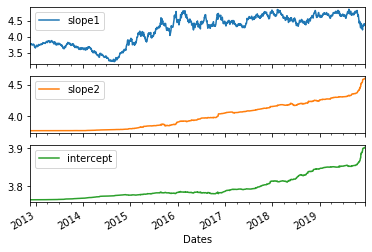

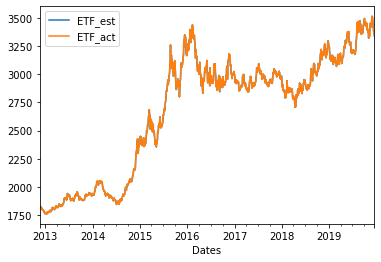

In [95]:
if __name__ == "__main__":
    file_name = 'KalmanExample.txt'
    #df = pd.read_csv(file_name, index_col = 0)
    prices = base[['USD/COP', 'USD/CLP', 'USD/BRL']]
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(3)
    obs_mat = np.vstack( [prices['USD/CLP'], prices['USD/BRL'],  
                          np.ones(prices['USD/CLP'].shape)]).T[:, np.newaxis]
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=3,
        initial_state_mean=np.zeros(3),
        initial_state_covariance=np.ones((3, 3)),
        transition_matrices=np.eye(3),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov        
    )

    # state_means, state_covs = kf.em(prices['ETF'].values).smooth(prices['ETF'].values)
    state_means, state_covs = kf.filter(prices['USD/COP'].values)


    # Re-construct ETF from coefficients and 'ASSET_1' and ASSET_2 values:
    ETF_est = np.array([a.dot(b) for a, b in zip(np.squeeze(obs_mat), state_means)])

    # Draw slope and intercept...
    pd.DataFrame(
        dict(
            slope1=state_means[:, 0],
            slope2=state_means[:, 1],
            intercept=state_means[:, 2],
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()

    # Draw actual y, and estimated y:
    datos_prediccion=pd.DataFrame(
        dict(
            ETF_est=ETF_est,
            ETF_act=prices['USD/COP'].values
        ), index=prices.index
    )
    datos_prediccion.plot()
    plt.show()

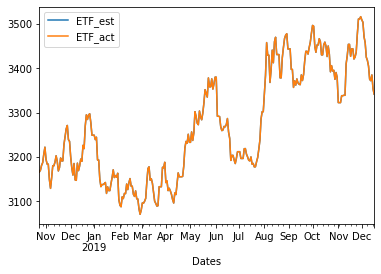

In [96]:
datos_prediccion[-300:].plot()

### Para multiples activos y sus rezagos
Voy a hacer dos ejercicio uno con los datos en el momento t y otro con los datos en t-1. Primero voy a hacerlo en el momento t.

#### Momento t
Creo una base de datos que contenga los activos a analizar. Debe dejar el USD/COP de primera y luego agregar los otros activos que quiera usar

In [106]:
activos=['SPX 500 vs ROW', 'SPX  vs COL', 'COLOM CDS USD SR 5Y D14 Corp', 'CL1 Comdty', 'US 10Y- COL 10Y', 'USD/BRL', 'USD/CLP',
       'USD/MXN', 'DXY']

In [119]:
df_1=base[activos].shift(0)
df_2=base[['USD/CLP', 'USD/BRL','USD/MXN', 'DXY','COLOM CDS USD SR 5Y D14 Corp','CL1 Comdty']].shift(1)
df=pd.DataFrame(base['USD/COP'])
df=df.join(df_1).bfill()
#f["rezago"]=base["USD/COP"].shift(1)

In [120]:
########################## Parámetros ##########################
numero_activos=len(df.columns)
prices = df.bfill()
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(numero_activos)

In [121]:
########################## Matriz de observaciones #################
# Empiezo en 1 porque 0 es el USD/COP
obs_mat=prices[prices.columns[1]]
for i in range(2,len(prices.columns)):
    obs_mat=np.vstack([obs_mat,prices[prices.columns[i]]])
obs_mat=np.vstack([obs_mat,np.ones(prices[prices.columns[1]].shape)]).T[:, np.newaxis]

#obs_mat = np.vstack( [prices['USD/BRL'],prices['USD/CLP'],prices['USD/MXN'], prices["DXY"],prices['COLOM CDS USD SR 5Y D14 Corp'],
#                      prices['CL1 Comdty'],
#                          np.ones(prices['USD/CLP'].shape)]).T[:, np.newaxis]


In [122]:
##################### Modelo del Filtro de kalman ####################
kf = KalmanFilter(
    n_dim_obs=1,
    n_dim_state=numero_activos,
    initial_state_mean=np.zeros(numero_activos),
    initial_state_covariance=np.ones((numero_activos, numero_activos)),
    transition_matrices=np.eye(numero_activos),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov        
    )

    # state_means, state_covs = kf.em(prices['ETF'].values).smooth(prices['ETF'].values)
state_means, state_covs = kf.filter(prices[prices.columns[0]].values)

In [123]:
################## Crear data frame de los betas ####################
dict_1={}
for i in range(0,len(prices.columns)-1):
    dict_1[prices.columns[i+1]]=state_means[:, i]
dict_1["intercept"]=state_means[:,len(prices.columns)-1]
datos_betas=pd.DataFrame(dict_1,index=prices.index)

#datos_betas=pd.DataFrame(
#    dict(
#        #beta_rezago=state_means[:, 0],
#        beta_real=state_means[:, 0],
#        beta_clp=state_means[:, 1],
#        beta_mxn=state_means[:, 2],
#        beta_dxy=state_means[:, 3],
#        beta_cds=state_means[:, 4],
#        beta_cl1=state_means[:, 5],
#        intercept=state_means[:, 6],
#        ), index=prices.index
#    )
datos_betas.tail()

,SPX 500 vs ROW,SPX vs COL,COLOM CDS USD SR 5Y D14 Corp,CL1 Comdty,US 10Y- COL 10Y,USD/BRL,USD/CLP,USD/MXN,DXY,intercept
Dates,,,,,,,,,,
2019-12-11,3.978088,2.420742,2.554741,-0.831905,1.312880,2.682524,2.935153,4.006186,7.192808,2.354572
2019-12-12,3.978207,2.420720,2.552484,-0.831523,1.313526,2.682400,2.937478,4.006016,7.194254,2.354568
2019-12-13,3.971576,2.420397,2.565423,-0.786490,1.303318,2.686942,2.975390,4.015840,7.219272,2.355113
2019-12-16,3.973833,2.419320,2.569833,-0.793188,1.301397,2.689227,2.949122,4.018598,7.215194,2.354943
2019-12-17,3.982911,2.419764,2.569990,-0.786731,1.300947,2.689994,2.956333,4.020631,7.219604,2.355027


In [130]:
datos_betas.tail(1).sort_values(by=datos_betas.index[len(datos_betas)-1],axis=1,ascending=False)
orden=datos_betas.tail(1).sort_values(by=datos_betas.index[len(datos_betas)-1],axis=1,ascending=False).columns

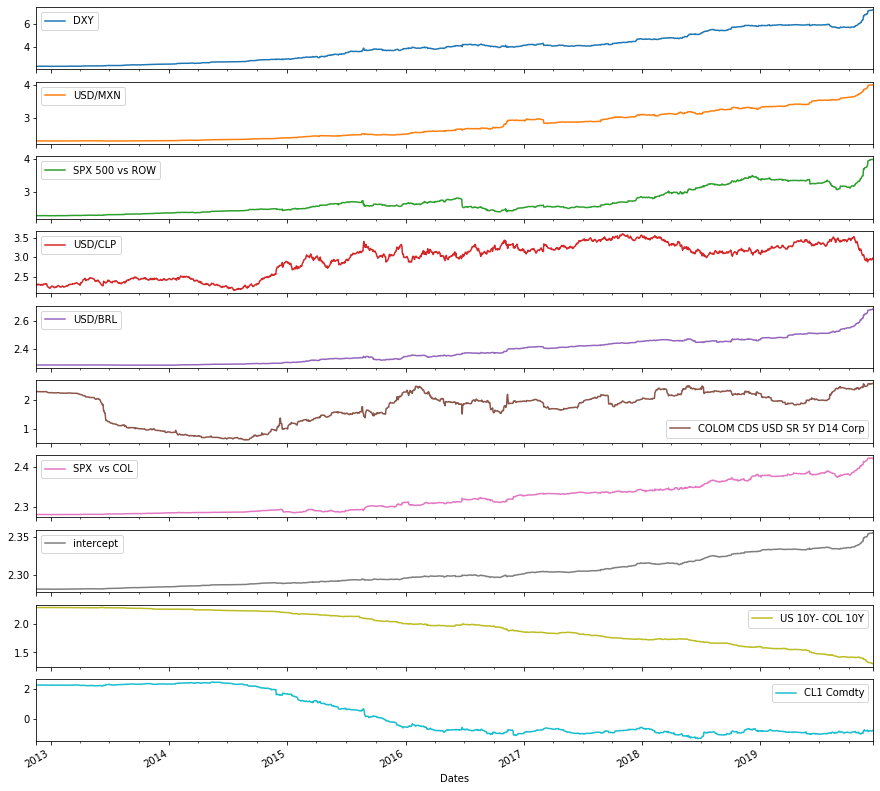

In [131]:
datos_betas[orden].plot(subplots=True,figsize=(15,15))
plt.show()

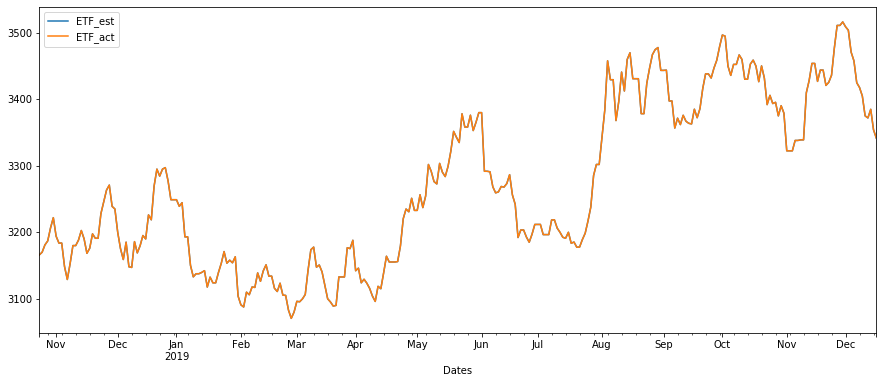

In [132]:
# Re-construct ETF from coefficients and 'ASSET_1' and ASSET_2 values:
ETF_est = np.array([a.dot(b) for a, b in zip(np.squeeze(obs_mat), state_means)])

# Draw actual y, and estimated y:
datos_prediccion=pd.DataFrame(
    dict(
        ETF_est=ETF_est,
        ETF_act=prices[prices.columns[0]].values
    ), index=prices.index)
datos_prediccion[-300:].plot(figsize=(15,6))
plt.show()

In [128]:
betas=datos_betas.shift().ffill()
betas.tail()

,SPX 500 vs ROW,SPX vs COL,COLOM CDS USD SR 5Y D14 Corp,CL1 Comdty,US 10Y- COL 10Y,USD/BRL,USD/CLP,USD/MXN,DXY,intercept
Dates,,,,,,,,,,
2019-12-11,3.972973,2.420414,2.560436,-0.831410,1.314499,2.682202,2.927643,4.004843,7.183689,2.354402
2019-12-12,3.978088,2.420742,2.554741,-0.831905,1.312880,2.682524,2.935153,4.006186,7.192808,2.354572
2019-12-13,3.978207,2.420720,2.552484,-0.831523,1.313526,2.682400,2.937478,4.006016,7.194254,2.354568
2019-12-16,3.971576,2.420397,2.565423,-0.786490,1.303318,2.686942,2.975390,4.015840,7.219272,2.355113
2019-12-17,3.973833,2.419320,2.569833,-0.793188,1.301397,2.689227,2.949122,4.018598,7.215194,2.354943


In [129]:
precios_prueba=pd.DataFrame(base[["USD/COP",'USD/BRL','USD/CLP','USD/MXN', 'DXY','COLOM CDS USD SR 5Y D14 Corp','CL1 Comdty']])
precios_prueba["intercepto"]=1
precios_prueba.tail()

,USD/COP,USD/BRL,USD/CLP,USD/MXN,DXY,COLOM CDS USD SR 5Y D14 Corp,CL1 Comdty,intercepto
Dates,,,,,,,,
2019-12-11,3375.1,4.1181,769.78,19.1176,97.078,75.760,58.76,1
2019-12-12,3372.0,4.0903,769.45,19.0597,97.452,73.227,59.18,1
2019-12-13,3385.0,4.1079,763.63,19.0407,97.171,72.927,60.07,1
2019-12-16,3354.1,4.0577,761.71,18.9323,96.965,72.122,60.21,1
2019-12-17,3341.6,4.0716,756.17,18.9283,96.777,71.259,60.88,1


In [117]:
prices['USD/COP'].tail()

Dates
2019-12-11    3375.1
2019-12-12    3372.0
2019-12-13    3385.0
2019-12-16    3354.1
2019-12-17    3341.6
Name: USD/COP, dtype: float64

In [118]:
pronostico=pd.DataFrame(np.multiply(np.array(precios_prueba), np.array(betas)).sum(axis=1), index=precios_prueba.index,columns=["pronostico"])
pronostico.tail()

ValueError: operands could not be broadcast together with shapes (1847,8) (1847,10) 

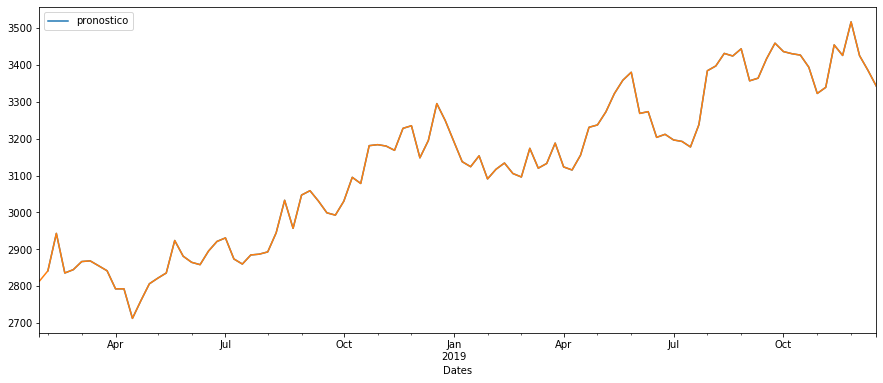

In [196]:
(pronostico[-100:].shift(1)).plot(figsize=(15,6))
prices['USD/COP'][-100:].plot(figsize=(15,6))
plt.show()


In [236]:
obs_mat = np.vstack( [prices['USD/CLP'],prices['USD/BRL'],prices['USD/MXN'], prices["DXY"],prices['COLOM CDS USD SR 5Y D14 Corp'],
                      prices['CL1 Comdty'],
                          np.ones(prices['USD/CLP'].shape)]).T[:, np.newaxis]

In [237]:
prices.columns

Index(['USD/COP', 'USD/CLP', 'USD/BRL', 'USD/MXN', 'DXY',
       'COLOM CDS USD SR 5Y D14 Corp', 'CL1 Comdty'],
      dtype='object')

In [255]:
prueba

array([[[478.77  ,   2.0815,  12.9647, ..., 100.169 ,  88.28  ,
           1.    ]],

       [[480.87  ,   2.136 ,  12.9667, ..., 101.075 ,  88.91  ,
           1.    ]],

       [[476.99  ,   2.0751,  12.8505, ...,  99.875 ,  85.93  ,
           1.    ]],

       ...,

       [[778.27  ,   4.1389,  19.3063, ...,  82.218 ,  59.2   ,
           1.    ]],

       [[763.63  ,   4.1079,  19.0407, ...,  72.927 ,  60.07  ,
           1.    ]],

       [[756.17  ,   4.0716,  18.9283, ...,  71.259 ,  60.88  ,
           1.    ]]])

In [256]:
obs_mat.shape

(370, 1, 7)

In [257]:
prueba[1]

array([[480.87  ,   2.136 ,  12.9667,  80.153 , 101.075 ,  88.91  ,
          1.    ]])

In [258]:
obs_mat[1]

array([[480.87  ,   2.136 ,  12.9667,  80.153 , 101.075 ,  88.91  ,
          1.    ]])

# Johansen test

In [38]:
'''
function result = johansen(x,p,k)
% PURPOSE: perform Johansen cointegration tests
% -------------------------------------------------------
% USAGE: result = johansen(x,p,k)
% where:      x = input matrix of time-series in levels, (nobs x m)
%             p = order of time polynomial in the null-hypothesis
%                 p = -1, no deterministic part
%                 p =  0, for constant term
%                 p =  1, for constant plus time-trend
%                 p >  1, for higher order polynomial
%             k = number of lagged difference terms used when
%                 computing the estimator
% -------------------------------------------------------
% RETURNS: a results structure:
%          result.eig  = eigenvalues  (m x 1)
%          result.evec = eigenvectors (m x m), where first
%                        r columns are normalized coint vectors
%          result.lr1  = likelihood ratio trace statistic for r=0 to m-1
%                        (m x 1) vector
%          result.lr2  = maximum eigenvalue statistic for r=0 to m-1
%                        (m x 1) vector
%          result.cvt  = critical values for trace statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.cvm  = critical values for max eigen value statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.ind  = index of co-integrating variables ordered by
%                        size of the eigenvalues from large to small
% -------------------------------------------------------
% NOTE: c_sja(), c_sjt() provide critical values generated using
%       a method of MacKinnon (1994, 1996).
%       critical values are available for n<=12 and -1 <= p <= 1,
%       zeros are returned for other cases.
% -------------------------------------------------------
% SEE ALSO: prt_coint, a function that prints results
% -------------------------------------------------------
% References: Johansen (1988), 'Statistical Analysis of Co-integration
% vectors', Journal of Economic Dynamics and Control, 12, pp. 231-254.
% MacKinnon, Haug, Michelis (1996) 'Numerical distribution
% functions of likelihood ratio tests for cointegration',
% Queen's University Institute for Economic Research Discussion paper.
% (see also: MacKinnon's JBES 1994 article
% -------------------------------------------------------

% written by:
% James P. LeSage, Dept of Economics
% University of Toledo
% 2801 W. Bancroft St,
% Toledo, OH 43606
% jlesage@spatial-econometrics.com

% ****************************************************************
% NOTE: Adina Enache provided some bug fixes and corrections that
%       she notes below in comments. 4/10/2000
% ****************************************************************
'''

import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS


tdiff = np.diff

class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1)).fit().resid

def resid(y, x):
    r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    return r




def coint_johansen(x, p, k, print_on_console=True):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    # why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    x = detrend(x, p)
    dx = tdiff(x, 1, axis=0)
    # dx    = trimr(dx,1,0)
    z = mlag(dx, k)  # [k-1:]
#    print z.shape
    z = trimr(z, k, 0)
    z = detrend(z, f)
#    print dx.shape
    dx = trimr(dx, k, 0)

    dx = detrend(dx, f)
    # r0t   = dx - z*(z\dx)
    r0t = resid(dx, z)  # diff on lagged diffs
    # lx = trimr(lag(x,k),k,0)
    lx = lag(x, k)
    lx = trimr(lx, 1, 0)
    dx = detrend(lx, f)
#    print 'rkt', dx.shape, z.shape
    # rkt   = dx - z*(z\dx)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rows(rkt)
    sk0 = np.dot(rkt.T, r0t) / rows(rkt)
    s00 = np.dot(r0t.T, r0t) / rows(r0t)
    sig = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    tmp = inv(skk)
    # du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  # au is eval, du is evec
    # orig = np.dot(tmp, sig)

    # % Normalize the eigen vectors such that (du'skk*du) = I
    temp = inv(chol(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)


    # JP: the next part can be done much  easier

    # %      NOTE: At this point, the eigenvectors are aligned by column. To
    # %            physically move the column elements using the MATLAB sort,
    # %            take the transpose to put the eigenvectors across the row

    # dt = transpose(dt)

    # % sort eigenvalues and vectors

    # au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    # a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    # d = dt[aind,:]
    d = dt[:, aind]

    # %NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    # %      Put the eigenvectors back in column format after the sort by taking the
    # %      transpose of "d". Since the eigenvectors have been physically moved, there is
    # %      no need for aind at all. To preserve existing programming, aind is reset back to
    # %      1, 2, 3, ....

    # d  =  transpose(d)
    # test = np.dot(transpose(d), np.dot(skk, d))

    # %EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    # %auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    # %physically moved the rows of dt (to d) based on the alignment in aind and then used
    # %aind as a column index to address the eigenvectors from high to low. This is a double
    # %sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    # %using aind as a reference, you would get the correct eigenvector, but with sorted
    # %coefficients and, therefore, any follow-on calculation would seem to be in error.
    # %If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    # %followed by a root extraction on the characteristic equation, then the roots can be
    # %quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    # %array can be operated on using the Cholesky transformation, which enables a unit
    # %diagonalization of skk. But nowhere along the way are the coefficients within the
    # %eigenvector array ever changed. The final value of the "beta" array using either method
    # %should be the same.


    # % Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m, 3))
    cvt = zeros((m, 3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(log(iota - a), i , 0)
        lr1[i] = -t * np.sum(tmp, 0)  # columnsum ?
        # tmp = np.log(1-a)
        # lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * log(1 - a[i])
        cvm[i, :] = c_sja(m - i, p)
        cvt[i, :] = c_sjt(m - i, p)
        aind[i] = i
    # end

    result = Holder()
    # % set up results structure
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  # transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    if print_on_console == True:
        print ('--------------------------------------------------')
        print ('--> Trace Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr1)):
            print ('r =', i, '\t', round(result.lr1[i], 4), result.cvt[i, 0], result.cvt[i, 1], result.cvt[i, 2])
        print ('--------------------------------------------------')
        print ('--> Eigen Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr2)):
            print ('r =', i, '\t', round(result.lr2[i], 4), result.cvm[i, 0], result.cvm[i, 1], result.cvm[i, 2])
        print ('--------------------------------------------------')
        print ('eigenvectors:\n', result.evec)
        print ('--------------------------------------------------')
        print ('eigenvalues:\n', result.eig)
        print ('--------------------------------------------------')


    return result

def c_sjt(n, p):

# PURPOSE: find critical values for Johansen trace statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sjt(n,p)
# where:    n = dimension of the VAR system
#               NOTE: routine doesn't work for n > 12
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the trace
#          statistic for [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# # References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
#
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com

# these are the values from Johansen's 1995 book
# for comparison to the MacKinnon values
# jcp0 = [ 2.98   4.14   7.02
#        10.35  12.21  16.16
#        21.58  24.08  29.19
#        36.58  39.71  46.00
#        55.54  59.24  66.71
#        78.30  86.36  91.12
#       104.93 109.93 119.58
#       135.16 140.74 151.70
#       169.30 175.47 187.82
#       207.21 214.07 226.95
#       248.77 256.23 270.47
#       293.83 301.95 318.14];




    jcp0 = ((2.9762, 4.1296, 6.9406),
            (10.4741, 12.3212, 16.3640),
            (21.7781, 24.2761, 29.5147),
            (37.0339, 40.1749, 46.5716),
            (56.2839, 60.0627, 67.6367),
            (79.5329, 83.9383, 92.7136),
            (106.7351, 111.7797, 121.7375),
            (137.9954, 143.6691, 154.7977),
            (173.2292, 179.5199, 191.8122),
            (212.4721, 219.4051, 232.8291),
            (255.6732, 263.2603, 277.9962),
            (302.9054, 311.1288, 326.9716))


    jcp1 = ((2.7055, 3.8415, 6.6349),
            (13.4294, 15.4943, 19.9349),
            (27.0669, 29.7961, 35.4628),
            (44.4929, 47.8545, 54.6815),
            (65.8202, 69.8189, 77.8202),
            (91.1090, 95.7542, 104.9637),
            (120.3673, 125.6185, 135.9825),
            (153.6341, 159.5290, 171.0905),
            (190.8714, 197.3772, 210.0366),
            (232.1030, 239.2468, 253.2526),
            (277.3740, 285.1402, 300.2821),
            (326.5354, 334.9795, 351.2150))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (16.1619, 18.3985, 23.1485),
            (32.0645, 35.0116, 41.0815),
            (51.6492, 55.2459, 62.5202),
            (75.1027, 79.3422, 87.7748),
            (102.4674, 107.3429, 116.9829),
            (133.7852, 139.2780, 150.0778),
            (169.0618, 175.1584, 187.1891),
            (208.3582, 215.1268, 228.2226),
            (251.6293, 259.0267, 273.3838),
            (298.8836, 306.8988, 322.4264),
            (350.1125, 358.7190, 375.3203))



    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]



    return jc

def c_sja(n, p):

# PURPOSE: find critical values for Johansen maximum eigenvalue statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sja(n,p)
# where:    n = dimension of the VAR system
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the maximum eigenvalue
#          statistic for: [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com


    jcp0 = ((2.9762, 4.1296, 6.9406),
            (9.4748, 11.2246, 15.0923),
            (15.7175, 17.7961, 22.2519),
            (21.8370, 24.1592, 29.0609),
            (27.9160, 30.4428, 35.7359),
            (33.9271, 36.6301, 42.2333),
            (39.9085, 42.7679, 48.6606),
            (45.8930, 48.8795, 55.0335),
            (51.8528, 54.9629, 61.3449),
            (57.7954, 61.0404, 67.6415),
            (63.7248, 67.0756, 73.8856),
            (69.6513, 73.0946, 80.0937))

    jcp1 = ((2.7055, 3.8415, 6.6349),
            (12.2971, 14.2639, 18.5200),
            (18.8928, 21.1314, 25.8650),
            (25.1236, 27.5858, 32.7172),
            (31.2379, 33.8777, 39.3693),
            (37.2786, 40.0763, 45.8662),
            (43.2947, 46.2299, 52.3069),
            (49.2855, 52.3622, 58.6634),
            (55.2412, 58.4332, 64.9960),
            (61.2041, 64.5040, 71.2525),
            (67.1307, 70.5392, 77.4877),
            (73.0563, 76.5734, 83.7105))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (15.0006, 17.1481, 21.7465),
            (21.8731, 24.2522, 29.2631),
            (28.2398, 30.8151, 36.1930),
            (34.4202, 37.1646, 42.8612),
            (40.5244, 43.4183, 49.4095),
            (46.5583, 49.5875, 55.8171),
            (52.5858, 55.7302, 62.1741),
            (58.5316, 61.8051, 68.5030),
            (64.5292, 67.9040, 74.7434),
            (70.4630, 73.9355, 81.0678),
            (76.4081, 79.9878, 87.2395))


    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]


    return jc